In [79]:
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt

from tmm import coh_tmm

In [80]:
from drjit.cuda import (
    Float,
    UInt32,
    Int32,
    Array4f,
    Array3f,
    Array2f,
    TensorXf,
    Complex2f,
    Matrix2f,
    Matrix4f,
    Loop,
)

In [81]:
from drjit.cuda import Matrix4f

x = Matrix4f(np.array([[1, 3, 3, 3], [1, 2, 2, 2], [1, 2, 2, 2], [1, 2, 2, 2]]))

Text(0.5, 1.0, 'Reflection of p-polarized light with Surface Plasmon Resonance\nCompare with http://doi.org/10.2320/matertrans.M2010003 Fig 6a')

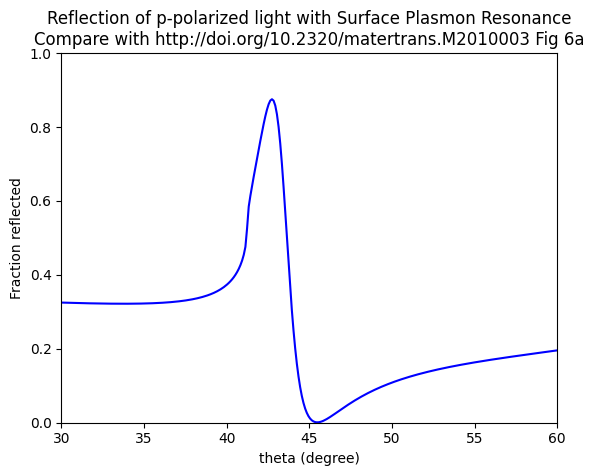

In [82]:
# list of layer thicknesses in nm
d_list = [np.inf, 5, 30, np.inf]
# list of refractive indices
n_list = [1.517, 3.719 + 4.362j, 0.130 + 3.162j, 1]
# wavelength in nm
lam_vac = 633
# list of angles to plot
theta_list = np.linspace(np.deg2rad(30), np.deg2rad(60), num=300)
# initialize lists of y-values to plot
Rp = []
for theta in theta_list:
    Rp.append(coh_tmm("p", n_list, d_list, theta, lam_vac)["R"])
plt.figure()
plt.plot(np.rad2deg(theta_list), Rp, "blue")
plt.xlabel("theta (degree)")
plt.ylabel("Fraction reflected")
plt.xlim(30, 60)
plt.ylim(0, 1)
plt.title(
    "Reflection of p-polarized light with Surface Plasmon Resonance\n"
    "Compare with http://doi.org/10.2320/matertrans.M2010003 Fig 6a"
)

In [83]:
Rp

[0.32509354200106994,
 0.324957492269462,
 0.3248231818789324,
 0.3246906779842171,
 0.3245600499796141,
 0.3244313695927897,
 0.324304710983334,
 0.3241801508463141,
 0.3240577685211518,
 0.3239376461061334,
 0.32381986857888767,
 0.3237045239232137,
 0.3235917032626387,
 0.32348150100112427,
 0.32337401497138485,
 0.32326934659128354,
 0.32316760102883196,
 0.32306888737635453,
 0.3229733188344052,
 0.3228810129060843,
 0.3227920916024481,
 0.32270668165975325,
 0.32262491476934263,
 0.3225469278210264,
 0.3224728631609119,
 0.32240286886466796,
 0.3223370990273342,
 0.32227571407083816,
 0.32221888107050745,
 0.3221667741019486,
 0.3221195746098049,
 0.3220774718000069,
 0.3220406630572916,
 0.32200935438990513,
 0.3219837609035809,
 0.321964107307074,
 0.3219506284517209,
 0.3219435699077499,
 0.32194318858028576,
 0.3219497533682879,
 0.3219635458699674,
 0.3219848611385551,
 0.32201400849268397,
 0.3220513123860572,
 0.32209711334154234,
 0.32215176895535275,
 0.3222156549775544,

In [84]:
# Represent a complex-valued matrix into real-valued matrix
# https://math.stackexchange.com/a/2012242

def get_rows(z11, z12, z21, z22):
    return (
        Array4f(z11.real, -z11.imag, z12.real, -z12.imag),
        Array4f(z11.imag, z11.real, z12.imag, z12.real),
        Array4f(z21.real, -z21.imag, z22.real, -z22.imag),
        Array4f(z21.imag, z21.real, z22.imag, z22.real)
    )

def get_big_matrix(row0, row1, row2, row3):
    return dr.transpose(Matrix4f(row0, row1, row2, row3))

def get_00(m):
    return Complex2f(m[0, 0], m[1, 0])

def get_10(m):
    return Complex2f(m[2, 0], m[3, 0])

# z11 = 1 + 5j
# z12 = 2 + 6j
# z21 = 3 + 7j
# z22 = 4 + 8j
# a = np.array(
#     [
#         [z11, z12],
#         [z21, z22],
#     ]
# )

# z11 = Complex2f(np.array([z11]))
# z12 = Complex2f(np.array([z12]))
# z21 = Complex2f(np.array([z21]))
# z22 = Complex2f(np.array([z22]))
# A = get_big_matrix(*get_rows(z11, z12, z21, z22))

# z11 = 5 + 1j
# z12 = 6 + 2j
# z21 = 7 + 3j
# z22 = 8 + 4j
# b = np.array(
#     [
#         [z11, z12],
#         [z21, z22],
#     ]
# )

# z11 = Complex2f(np.array([z11]))
# z12 = Complex2f(np.array([z12]))
# z21 = Complex2f(np.array([z21]))
# z22 = Complex2f(np.array([z22]))
# B = get_big_matrix(*get_rows(z11, z12, z21, z22))

# t = 1 / (2.5 + 3.0j)
# mulab = t * a @ b

# t = 1 / Complex2f(np.array([2.5 + 3.0j]))
# T = get_big_matrix(*get_rows(t, 0, 0, t))
# mulAB = T @ A @ B

# print("mulab")
# print(mulab)
# print("")

# print("mulAB")
# print(mulAB)

# # Since in tmm we have Mtilde[1, 0] / Mtilde[0, 0]
# # that means getting:
# # z11.real + iz11.imag (Mtilde[0, 0])
# # z21.real + iz21.imag (Mtilde[1, 0])
# print(mulab[0, 0], mulab[1, 0])
# print(get_00(mulAB), get_10(mulAB))

In [85]:
def is_forward_angle(n, theta):
    ncostheta = n * dr.cos(theta)

    m = dr.abs(ncostheta.imag) > 100 * dr.epsilon(Float)
    answer = dr.select(m, ncostheta.imag > 0, ncostheta.real > 0)

    return answer

def list_snell(n_list, th_0):
    n0_ = n_list[0] * dr.sin(th_0) / n_list

    angles = dr.asin(n0_)

    indices = UInt32([0, dr.width(n_list) - 1])
    n_result = dr.gather(Complex2f, n_list, indices)
    angles_result = dr.gather(Complex2f, angles, indices)

    # The first and last entry need to be the forward angle (the intermediate
    # layers don't matter, see https://arxiv.org/abs/1603.02720 Section 5)
    not_is_forward_angle = ~is_forward_angle(n_result, angles_result)
    angles_result = dr.select(not_is_forward_angle, dr.pi - angles_result, angles_result)
    dr.scatter(angles, angles_result, indices)

    return angles

def interface_t(polarization, n_i, n_f, th_i, th_f):
    if polarization == "s":
        return 2.0 * n_i * dr.cos(th_i) / (n_i * dr.cos(th_i) + n_f * dr.cos(th_f))
    elif polarization == "p":
        return 2.0 * n_i * dr.cos(th_i) / (n_f * dr.cos(th_i) + n_i * dr.cos(th_f))
    else:
        raise ValueError("Polarization must be 's' or 'p'")

def interface_r(polarization, n_i, n_f, th_i, th_f):
    if polarization == "s":
        return (n_i * dr.cos(th_i) - n_f * dr.cos(th_f)) / (n_i * dr.cos(th_i) + n_f * dr.cos(th_f))
    elif polarization == "p":
        return (n_f * dr.cos(th_i) - n_i * dr.cos(th_f)) / (n_f * dr.cos(th_i) + n_i * dr.cos(th_f))
    else:
        raise ValueError("Polarization must be 's' or 'p'")

def R_from_r(r):
    return dr.abs(r) ** 2

def coh_tmm_dr(pol, n_list, d_list, th_0, lam_vac):
    num_layers = dr.width(n_list)

    th_list = list_snell(n_list, th_0)

    print(th_list.numpy())

    kz_list = 2.0 * dr.pi * n_list * dr.cos(th_list) / lam_vac

    delta = kz_list * d_list

    # Get the first and last layer so they can be reset to their original values
    indices = UInt32([0, num_layers - 1])
    delta_result = dr.gather(Complex2f, delta, indices)

    # For a very opaque layer, reset delta to avoid divide-by-0 and similar
    # errors. The criterion imag(delta) > 35 corresponds to single-pass
    # transmission < 1e-30 --- small enough that the exact value doesn't
    # matter.
    delta = dr.select(delta.imag > 35, delta.real + Complex2f(35j), delta)
    # Reset the first and last layer to their original values
    dr.scatter(delta, delta_result, indices)

    # t_list[i,j] and r_list[i,j] are transmission and reflection amplitudes,
    # respectively, coming from i, going to j. Only need to calculate this when
    # j=i+1. (2D array is overkill but helps avoid confusion.)
    t_list = dr.zeros(Complex2f, num_layers * num_layers)
    r_list = dr.zeros(Complex2f, num_layers * num_layers)
    for i in range(num_layers - 1):
        n_list_i = Complex2f(dr.slice(n_list, i))
        n_list_j = Complex2f(dr.slice(n_list, i + 1))
        th_list_i = Complex2f(dr.slice(th_list, i))
        th_list_j = Complex2f(dr.slice(th_list, i + 1))

        t_list_result = interface_t(pol, n_list_i, n_list_j, th_list_i, th_list_j)
        r_list_result = interface_r(pol, n_list_i, n_list_j, th_list_i, th_list_j)

        index = UInt32([i * num_layers + i + 1])
        dr.scatter(t_list, t_list_result, index)
        dr.scatter(r_list, r_list_result, index)

    M_list = dr.zeros(Matrix4f, num_layers)
    for i in range(1, num_layers - 1):
        t = 1 / Complex2f(dr.slice(t_list, i * num_layers + i + 1))
        r = Complex2f(dr.slice(r_list, i * num_layers + i + 1))
        d = Complex2f(dr.slice(delta, i))

        T = get_big_matrix(*get_rows(t, 0, 0, t))

        A = get_big_matrix(
            *get_rows(dr.exp(Complex2f(0, -1) * d),
                      0,
                      0,
                      dr.exp(Complex2f(0, 1) * d))
        )

        B = get_big_matrix(*get_rows(1, r, r, 1))

        M = T @ (A @ B)
        dr.scatter(M_list, M, UInt32([i]))


    Mtilde = get_big_matrix(*get_rows(1, 0, 0, 1))
    for i in range(1, num_layers - 1):
        Mtilde = Mtilde @ Matrix4f(dr.slice(M_list, i))

    t01 = 1 / Complex2f(dr.slice(t_list, 0 * num_layers + 1))
    T01 = get_big_matrix(*get_rows(t01, 0, 0, t01))
    Mtilde = get_big_matrix(*get_rows(1,
                                      Complex2f(dr.slice(r_list, 0 * num_layers + 1)),
                                      Complex2f(dr.slice(r_list, 0 * num_layers + 1)),
                                      1)) @ T01 @ Mtilde

    r = get_10(Mtilde) / get_00(Mtilde)
    t = 1 / get_00(Mtilde)

    R = R_from_r(r)
    # T = T_from_t(pol, t, )

    return {
        "r" : r,
        "R" : R
    }

[0.5235991 -9.6806325e-08j 0.20552139-2.4956246e-01j
 0.00084354-2.0520477e-02j 0.523599  -0.0000000e+00j]
[0.5253503-9.6806325e-08j 0.2061139-2.5033388e-01j
 0.0008461-2.0582715e-02j 0.5253502-0.0000000e+00j]
[0.52710146-0.j         0.20670551-0.25110477j 0.00084865-0.02064495j
 0.52710134-0.j        ]
[0.5288526 +4.1002108e-09j 0.20729625-2.5187510e-01j
 0.00085121-2.0706823e-02j 0.5288526 +4.1002108e-09j]
[0.5306038 -0.j         0.20788613-0.2526445j  0.00085375-0.02076893j
 0.53060377-0.j        ]
[0.5323549 -0.j         0.20847508-0.2534133j  0.0008563 -0.02083084j
 0.5323549 -0.j        ]
[0.5341061 -0.j         0.20906319-0.25418147j 0.00085884-0.02089282j
 0.5341061 -0.j        ]
[0.5358573 -0.j         0.20965041-0.2549489j  0.00086138-0.02095455j
 0.5358573 -0.j        ]
[0.5376086 +3.4138161e-08j 0.2102367 -2.5571573e-01j
 0.00086392-2.1016398e-02j 0.53760856+4.1002108e-09j]
[0.5393597 +4.1002108e-09j 0.21082208-2.5648180e-01j
 0.00086646-2.1077998e-02j 0.5393597 +4.1002108e

Text(0.5, 1.0, 'Reflection of p-polarized light with Surface Plasmon Resonance\nCompare with http://doi.org/10.2320/matertrans.M2010003 Fig 6a')

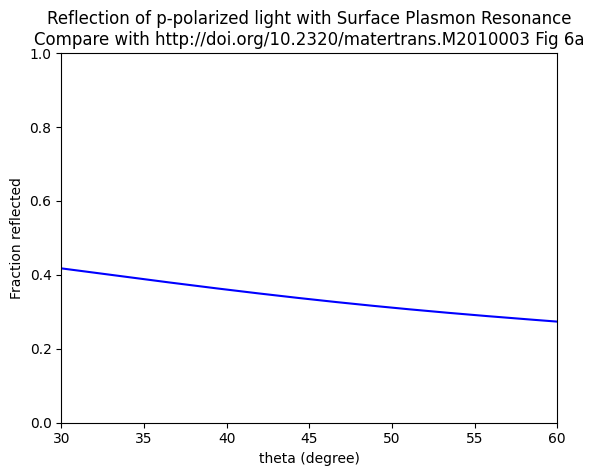

In [86]:
d_list = Float([dr.inf, 5, 30, dr.inf])
n_list = Complex2f(np.array([1.517, 3.719 + 4.362j, 0.130 + 3.162j, 1]))

lam_vac = 633

theta_list = dr.linspace(Float, dr.deg2rad(30), dr.deg2rad(60), num=300)
Rp = []
for theta in theta_list:
    Rp.append(coh_tmm_dr("p", n_list, d_list, theta, lam_vac)["R"])

plt.figure()
plt.plot(np.rad2deg(theta_list.numpy()), Rp, "blue")
plt.xlabel("theta (degree)")
plt.ylabel("Fraction reflected")
plt.xlim(30, 60)
plt.ylim(0, 1)
plt.title(
    "Reflection of p-polarized light with Surface Plasmon Resonance\n"
    "Compare with http://doi.org/10.2320/matertrans.M2010003 Fig 6a"
)

In [87]:
Rp

[[0.4176231324672699],
 [0.41703346371650696],
 [0.4164430499076843],
 [0.4158529043197632],
 [0.4152625799179077],
 [0.4146724343299866],
 [0.41408154368400574],
 [0.4134911000728607],
 [0.4129005968570709],
 [0.4123101234436035],
 [0.4117197096347809],
 [0.4111297130584717],
 [0.41053879261016846],
 [0.4099489450454712],
 [0.4093581736087799],
 [0.4087678790092468],
 [0.40817779302597046],
 [0.40758752822875977],
 [0.40699753165245056],
 [0.40640774369239807],
 [0.4058176279067993],
 [0.40522855520248413],
 [0.40463873744010925],
 [0.4040498435497284],
 [0.40346044301986694],
 [0.4028715491294861],
 [0.40228310227394104],
 [0.4016943871974945],
 [0.40110597014427185],
 [0.40051767230033875],
 [0.3999299705028534],
 [0.3993423581123352],
 [0.3987549841403961],
 [0.3981679677963257],
 [0.3975817561149597],
 [0.39699506759643555],
 [0.3964087665081024],
 [0.3958233892917633],
 [0.39523786306381226],
 [0.39465299248695374],
 [0.3940677046775818],
 [0.39348340034484863],
 [0.3928996026515